In [20]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.utils import resample
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import seaborn as sns

# **LOAD HATE DATASET**

In [2]:
data = pd.read_csv(r"/content/hate.csv",encoding = "ISO-8859-1", engine= "python")
data.drop(columns=['Unnamed: 0'], inplace=True)
data

,comment,label
0,dalits are lowlives,N
1,gay people are a burden to our society,N
2,Arabs are not welcome,N
3,I'm not saying we should actually eliminate he...,N
4,bananas are for black people,N
...,...,...
41139,Indian culture is so backwards,N
41140,"Women don't want equality, they just want to b...",N
41141,fuck covid,P
41142,This computer is garbage,P


**DATA PRE-PROCESSING**
---
Data preprocessing is a crucial step in machine learning to ensure the data is clean, consistent, and ready for model training. It includes operations like handling missing values, removing duplicates, encoding categorical variables, and feature extraction to make the dataset suitable for machine learning algorithms.



In [3]:

# Drop rows where the target label is missing
data.dropna(subset=['label'], inplace=True)

# Fill any missing comment text with an empty string (if applicable)
data['comment'] = data['comment'].fillna("")

# Drop rows where 'comment' is an empty string
data = data[data['comment'].str.strip() != ""]

# Print the number of rows remaining after filtering empty comments
print(f"Remaining rows after filtering empty comments: {len(data)}")

# Remove rows where the label is 'O'
data = data[data['label'] != 'O']

# Optionally, print the number of rows remaining after filtering
print(f"Remaining rows after removing 'O': {len(data)}")
# Ensure the target variable 'y' has no missing values, fill them with 0 (if any)
y = data['label']
y = y.fillna('N')  # If NaN values exist, replace them with 0

data

Remaining rows after filtering empty comments: 41144
Remaining rows after removing 'O': 41108


,comment,label
0,dalits are lowlives,N
1,gay people are a burden to our society,N
2,Arabs are not welcome,N
3,I'm not saying we should actually eliminate he...,N
4,bananas are for black people,N
...,...,...
41139,Indian culture is so backwards,N
41140,"Women don't want equality, they just want to b...",N
41141,fuck covid,P
41142,This computer is garbage,P


In [4]:
# Example: One-Hot Encoding for categorical features (if any)
encoder = OneHotEncoder(sparse_output=False)
if 'category' in data.columns:
    encoded_features = encoder.fit_transform(data[['category']])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['category']))
    data = pd.concat([data, encoded_df], axis=1).drop('category', axis=1)

# Scale the length of the comments (to treat the length as a feature)
scaler = StandardScaler()
data['scaled_text_length'] = scaler.fit_transform(data['comment'].str.len().values.reshape(-1, 1))

**Exploratory Data Analysis (EDA)**
---
Exploratory Data Analysis (EDA) involves visualizing feature distributions (using histograms or KDE plots) and analyzing the target variable's balance with bar charts or histograms. Correlation heatmaps reveal relationships between features, while techniques like SMOTE address class imbalance for better model performance.


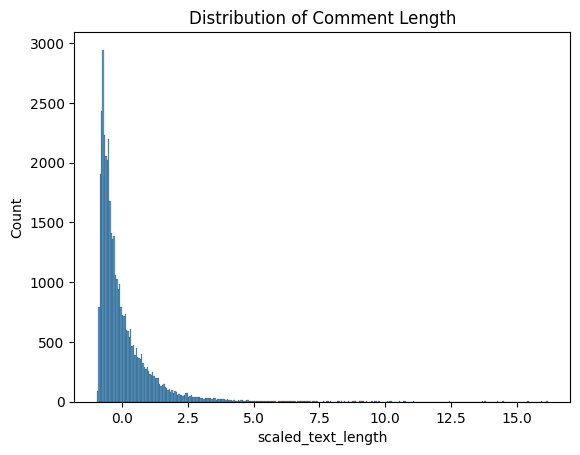

In [5]:
# Visualize the distribution of the comment lengths
sns.histplot(data['scaled_text_length'])
plt.title('Distribution of Comment Length')
plt.show()

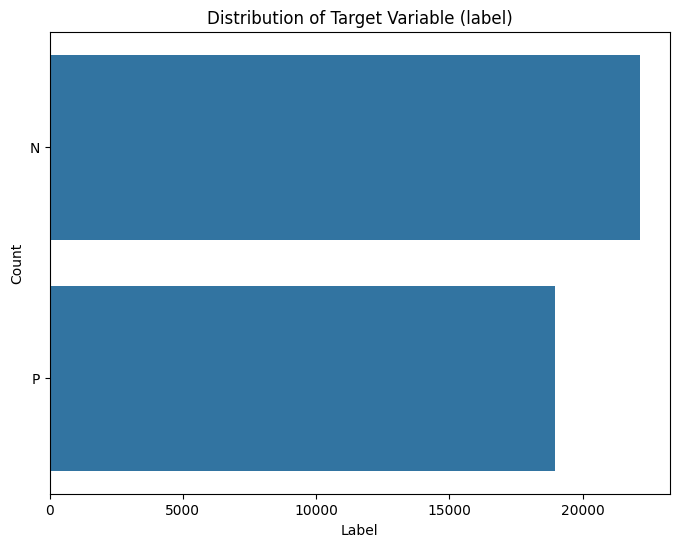

In [6]:
# Plot the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(data['label'])
plt.title("Distribution of Target Variable (label)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


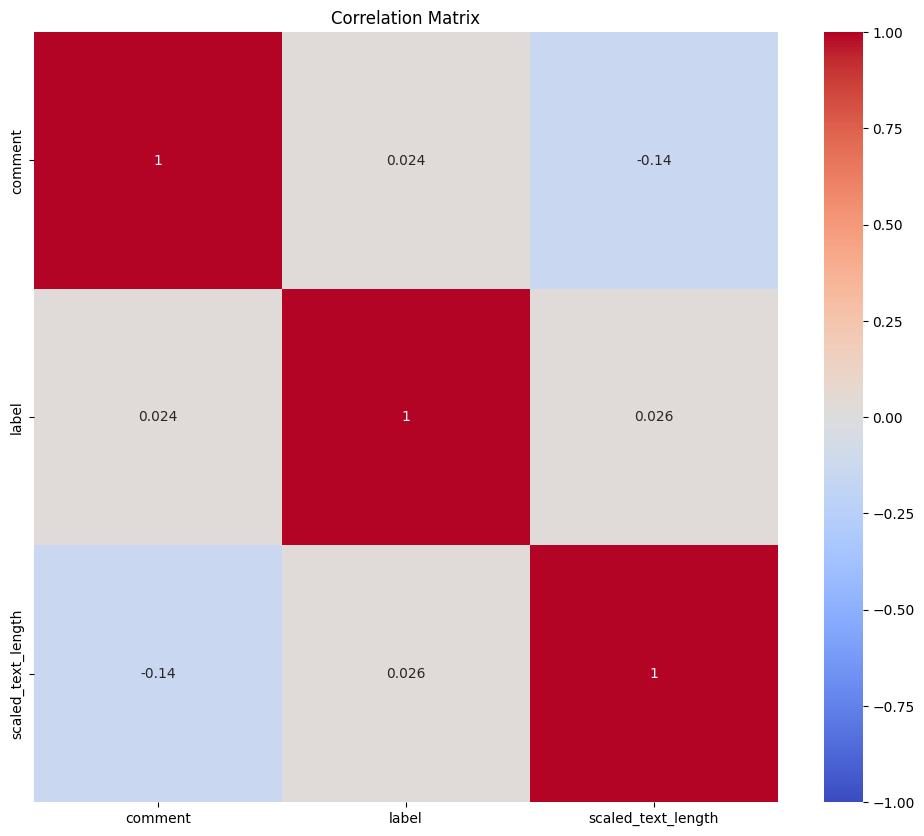

Correlation of Features with Target Variable:
label                 1.000000
scaled_text_length    0.026063
comment               0.024415
Name: label, dtype: float64


In [7]:
from sklearn.preprocessing import LabelEncoder

# Assume 'df' is the original DataFrame
df_encoded = data.copy()

# Encode text columns as numeric
label_encoder = LabelEncoder()
for col in data.columns:
    if data[col].dtype == 'object':
        df_encoded[col] = label_encoder.fit_transform(data[col])
# Calculate the correlation matrix
corr_matrix = df_encoded.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

# Calculate the correlation between features and target
target_correlations = df_encoded.corr()['label'].sort_values(ascending=False)

# Print the results
print("Correlation of Features with Target Variable:")
print(target_correlations)



**To address class imbalance by randomly undersampling the majority class. This balances the dataset but reduces the size of the majority class.**

**Apply TrainTestSplit and GridSearchCV as well as cross-validation**

In [8]:
# Lemmatization
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
data['comment'] = data['comment'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

data['label'] = data['label'].apply(lambda x: 1 if x == 'N' else 0)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1, 3), min_df=5, max_df=0.7)
X_vectorized = vectorizer.fit_transform(data['comment'])
y = data['label']

# SMOTE for Balancing
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_vectorized, y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

[nltk_data] Downloading package wordnet to /root/nltk_data...


# **Naive Bayes Classifier**

In [13]:
# Define Naive Bayes Classifier
nb_model = MultinomialNB()

# Parameter Grid
nb_param_grid = {
    'alpha': [0.1, 0.5, 1.0, 5.0, 10.0]
}

# Grid Search
grid_search = GridSearchCV(
    estimator=nb_model,
    param_grid=nb_param_grid,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5),
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

# Best Model and Parameters
best_nb_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Evaluate the Model
y_pred = best_nb_model.predict(X_test)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_nb_model.predict_proba(X_test)[:, 1])
accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy

print("\nModel Evaluation:")
print(f"F1 Score: {f1}")
print(f"ROC-AUC Score: {roc_auc}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
print(f"Accuracy: {accuracy:.2f}")  # Print accuracy

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'alpha': 10.0}

Model Evaluation:
F1 Score: 0.666372948562617
ROC-AUC Score: 0.7336392147279243
Confusion Matrix:
[[2810 1654]
 [1375 3025]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.63      0.65      4464
           1       0.65      0.69      0.67      4400

    accuracy                           0.66      8864
   macro avg       0.66      0.66      0.66      8864
weighted avg       0.66      0.66      0.66      8864

Accuracy: 0.66


# **Logistic regression**

In [14]:
from sklearn.linear_model import LogisticRegression
# Define Logistic Regression and its parameter grid
logistic_regression = LogisticRegression(random_state=42, solver='liblinear')
logistic_params = {
    "C": [0.01, 0.1, 1, 10],  # Regularization strength
    "penalty": ['l1', 'l2']    # Regularization type
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=logistic_regression,
    param_grid=logistic_params,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Train the model
print("Training Logistic Regression...")
grid_search.fit(X_train, y_train)

# Get the best model and parameters
best_logistic_model = grid_search.best_estimator_
print(f"\nBest parameters for Logistic Regression: {grid_search.best_params_}")

# Evaluate the model
print("\nEvaluating Logistic Regression...")
y_pred = best_logistic_model.predict(X_test)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_logistic_model.predict_proba(X_test)[:, 1])
accuracy = accuracy_score(y_test, y_pred)

# Print evaluation results
print("\nEvaluation Results for Logistic Regression:")
print(f"F1 Score: {f1}")
print(f"ROC-AUC Score: {roc_auc}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")


Training Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l1'}

Evaluating Logistic Regression...

Evaluation Results for Logistic Regression:
F1 Score: 0.7067988668555241
ROC-AUC Score: 0.79322420271261
Accuracy: 0.72
Confusion Matrix:
[[3386 1078]
 [1406 2994]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.76      0.73      4464
           1       0.74      0.68      0.71      4400

    accuracy                           0.72      8864
   macro avg       0.72      0.72      0.72      8864
weighted avg       0.72      0.72      0.72      8864



# **GradientBoostingClassifier**

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score

# Define GradientBoostingClassifier and its parameter grid
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_params = {
    "n_estimators": [50, 100],   # Number of boosting stages
    "learning_rate": [0.01, 0.1],  # Step size shrinkage
    "max_depth": [3],           # Maximum depth of individual trees
    "min_samples_split": [2],      # Minimum samples required to split an internal node
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=gb_classifier,
    param_grid=gb_params,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Train the model
print("Training Gradient Boosting Classifier...")
grid_search.fit(X_train, y_train)

# Get the best model and parameters
best_gb_model = grid_search.best_estimator_
print(f"\nBest parameters for Gradient Boosting: {grid_search.best_params_}")

# Evaluate the model
print("\nEvaluating Gradient Boosting Classifier...")
y_pred = best_gb_model.predict(X_test)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_gb_model.predict_proba(X_test)[:, 1])
accuracy = accuracy_score(y_test, y_pred)

# Print evaluation results
print("\nEvaluation Results for Gradient Boosting Classifier:")
print(f"F1 Score: {f1}")
print(f"ROC-AUC Score: {roc_auc}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")


Training Gradient Boosting Classifier...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}

Evaluating Gradient Boosting Classifier...

Evaluation Results for Gradient Boosting Classifier:
F1 Score: 0.6132147395171538
ROC-AUC Score: 0.6998632748859563
Accuracy: 0.66
Confusion Matrix:
[[3407 1057]
 [1987 2413]]
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.76      0.69      4464
           1       0.70      0.55      0.61      4400

    accuracy                           0.66      8864
   macro avg       0.66      0.66      0.65      8864
weighted avg       0.66      0.66      0.65      8864



# **Neural Network : MLPClassifier**

In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score

# Define MLPClassifier and its parameter grid
mlp_classifier = MLPClassifier(random_state=42, max_iter=500)
mlp_params = {
    "hidden_layer_sizes": [(50,)],  # Different layer configurations
    "activation": ['relu'],                 # Activation functions
    "alpha": [0.0001],                 # L2 regularization
    "learning_rate": ['constant']       # Learning rate strategies
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=mlp_classifier,
    param_grid=mlp_params,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Train the model
print("Training Neural Network (MLPClassifier)...")
grid_search.fit(X_train, y_train)

# Get the best model and parameters
best_mlp_model = grid_search.best_estimator_
print(f"\nBest parameters for Neural Network: {grid_search.best_params_}")

# Evaluate the model
print("\nEvaluating Neural Network...")
y_pred = best_mlp_model.predict(X_test)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_mlp_model.predict_proba(X_test)[:, 1])
accuracy = accuracy_score(y_test, y_pred)

# Print evaluation results
print("\nEvaluation Results for Neural Network:")
print(f"F1 Score: {f1}")
print(f"ROC-AUC Score: {roc_auc}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")


Training Neural Network (MLPClassifier)...
Fitting 2 folds for each of 1 candidates, totalling 2 fits

Best parameters for Neural Network: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant'}

Evaluating Neural Network...

Evaluation Results for Neural Network:
F1 Score: 0.6476810414971521
ROC-AUC Score: 0.7010223199739329
Accuracy: 0.66
Confusion Matrix:
[[3047 1417]
 [1614 2786]]
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.68      0.67      4464
           1       0.66      0.63      0.65      4400

    accuracy                           0.66      8864
   macro avg       0.66      0.66      0.66      8864
weighted avg       0.66      0.66      0.66      8864



# **Random Forest**

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score

# Define RandomForestClassifier and its parameter grid
rf_classifier = RandomForestClassifier(random_state=42)
rf_params = {
    "n_estimators": [50, 100],         # Number of trees in the forest
    "max_depth": [None, 10],            # Maximum depth of the trees
    "min_samples_split": [2, 5],        # Minimum samples required to split a node
    "min_samples_leaf": [1, 2],          # Minimum samples required at a leaf node
    "max_features": ['sqrt'],       # Number of features to consider at each split
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_classifier,
    param_grid=rf_params,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Train the model
print("Training Random Forest Classifier...")
grid_search.fit(X_train, y_train)

# Get the best model and parameters
best_rf_model = grid_search.best_estimator_
print(f"\nBest parameters for Random Forest: {grid_search.best_params_}")

# Evaluate the model
print("\nEvaluating Random Forest Classifier...")
y_pred = best_rf_model.predict(X_test)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_rf_model.predict_proba(X_test)[:, 1])
accuracy = accuracy_score(y_test, y_pred)

# Print evaluation results
print("\nEvaluation Results for Random Forest Classifier:")
print(f"F1 Score: {f1}")
print(f"ROC-AUC Score: {roc_auc}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")


Training Random Forest Classifier...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Best parameters for Random Forest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

Evaluating Random Forest Classifier...

Evaluation Results for Random Forest Classifier:
F1 Score: 0.6902143729867822
ROC-AUC Score: 0.7646136516373411
Accuracy: 0.69
Confusion Matrix:
[[2968 1496]
 [1293 3107]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.66      0.68      4464
           1       0.67      0.71      0.69      4400

    accuracy                           0.69      8864
   macro avg       0.69      0.69      0.69      8864
weighted avg       0.69      0.69      0.69      8864



# **XGBoostClassifier**

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:53:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:53:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   5.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:53:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:53:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:53:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:53:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.2, max_depth=7, n_estimators=50, subsample=1.0; total time=  13.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:53:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.2, max_depth=7, n_estimators=50, subsample=1.0; total time=  12.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:53:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.2, max_depth=7, n_estimators=50, subsample=1.0; total time=  12.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:53:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.2, max_depth=7, n_estimators=50, subsample=1.0; total time=  12.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:54:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.2, max_depth=7, n_estimators=50, subsample=1.0; total time=  11.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:54:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.8; total time=  11.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:54:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.8; total time=  10.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:54:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.8; total time=  19.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:55:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.8; total time=  18.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:55:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.8; total time=  16.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:55:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.8; total time=  16.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:55:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.8; total time=  19.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:56:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.8; total time=  15.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:56:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.8; total time=  15.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:56:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.8; total time=  16.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:57:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=  14.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:57:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=  21.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:57:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=  13.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:57:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=  18.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:58:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=  13.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:58:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=  18.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:58:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=  15.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:58:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=  14.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:59:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=  14.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:59:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=  14.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:59:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=  56.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:00:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=  58.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:01:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=  56.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:02:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=  56.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:03:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=  58.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=  40.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:05:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=  41.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:05:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=  43.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:06:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=  41.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:07:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=  40.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:07:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   8.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:08:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   8.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:08:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   6.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:08:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   8.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:08:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   6.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:08:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=  23.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:09:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=  25.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:09:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=  21.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:09:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=  23.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:10:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:10:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.74      0.71      4464
           1       0.71      0.66      0.68      4400

    accuracy                           0.70      8864
   macro avg       0.70      0.70      0.70      8864
weighted avg       0.70      0.70      0.70      8864



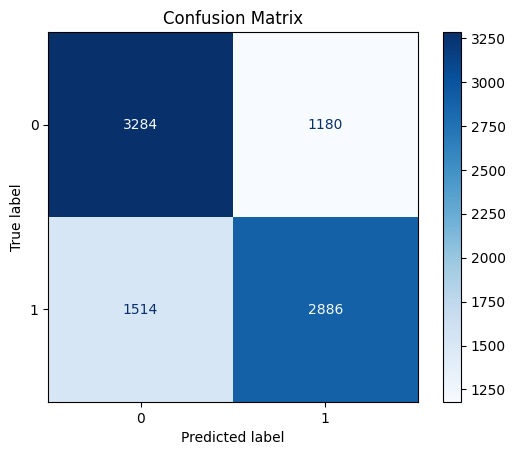

F1 Score: 0.6818


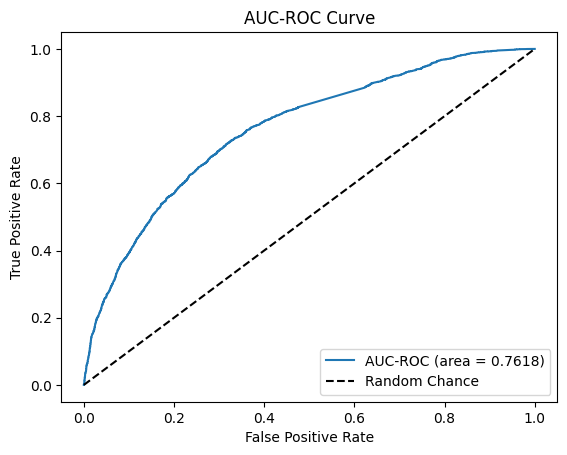

 99%|===================| 8818/8864 [01:13<00:00]       

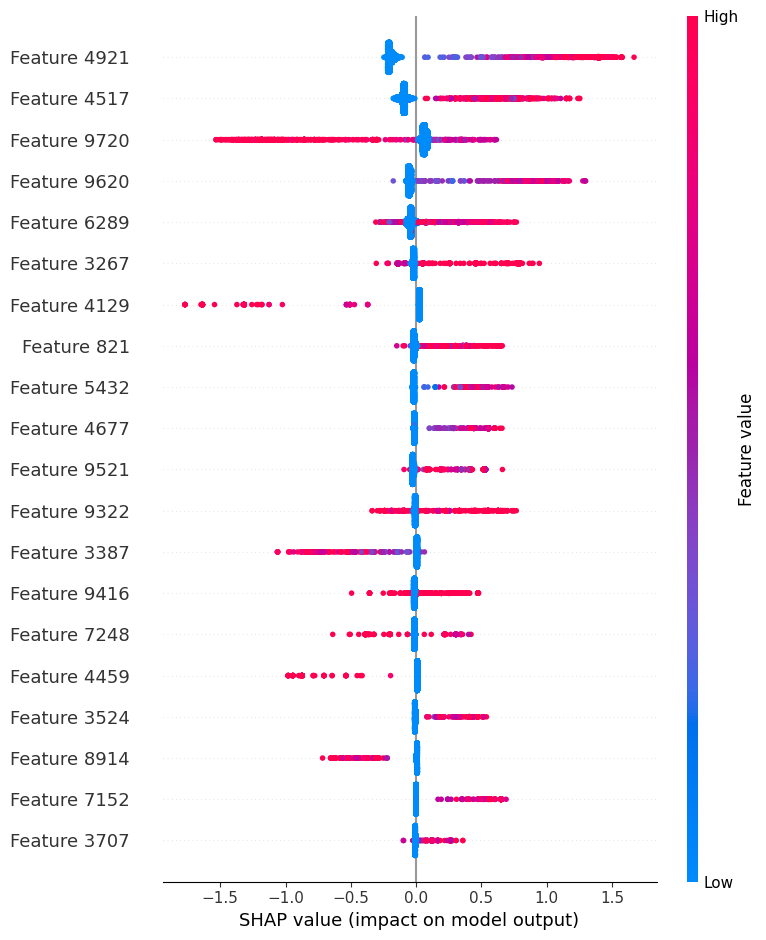

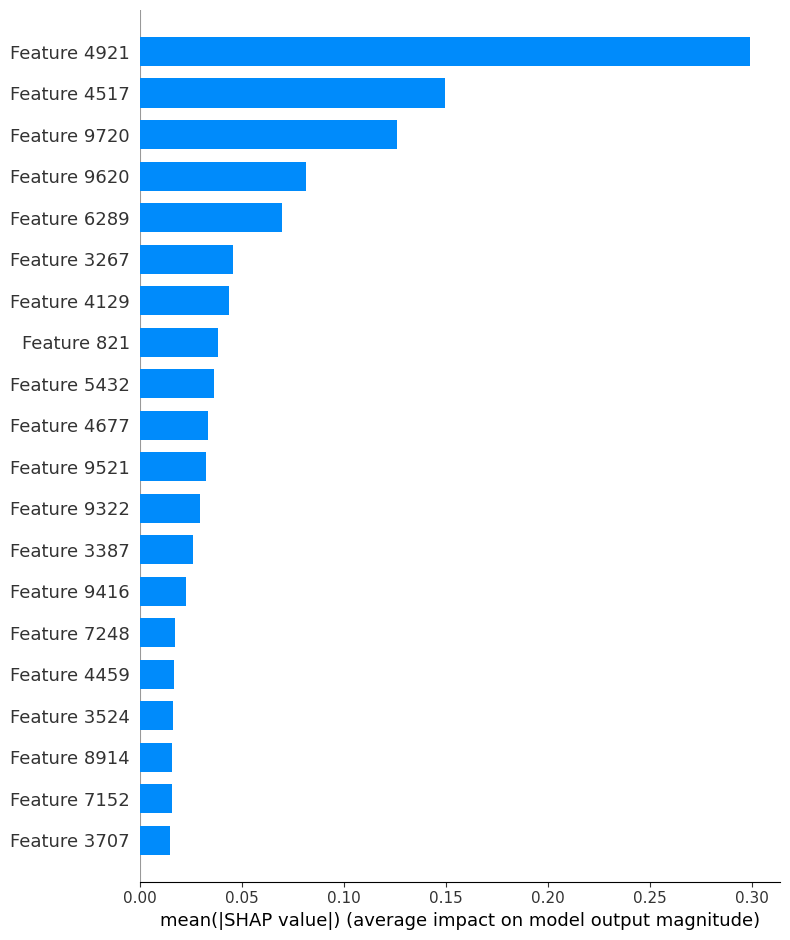

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score, roc_curve, classification_report
import shap

# XGBoost Classifier Model
from xgboost import XGBClassifier

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Hyperparameter tuning for XGBoost
xgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}
xgb_search = RandomizedSearchCV(xgb_model, param_distributions=xgb_params, cv=5, n_iter=10, scoring='accuracy', random_state=42, verbose=2)
xgb_search.fit(X_train, y_train)

# Best XGBoost model evaluation
xgb_best = xgb_search.best_estimator_
y_pred_xgb = xgb_best.predict(X_test)
y_proba_xgb = xgb_best.predict_proba(X_test)[:, 1]  # Assuming binary classification

# Classification report
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# F1 Score
f1 = f1_score(y_test, y_pred_xgb, average='binary')  # Adjust average parameter for multiclass
print(f"F1 Score: {f1:.4f}")

# AUC-ROC Curve
auc_roc = roc_auc_score(y_test, y_proba_xgb)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_xgb)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC-ROC (area = {auc_roc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Convert X_train and X_test to dense format
X_train_dense = X_train.toarray() if hasattr(X_train, 'toarray') else X_train
X_test_dense = X_test.toarray() if hasattr(X_test, 'toarray') else X_test

# SHAP Values
explainer = shap.Explainer(xgb_best, X_train_dense)
shap_values = explainer(X_test_dense)

# SHAP summary plot
shap.summary_plot(shap_values, X_test_dense)

# SHAP feature importance plot
shap.summary_plot(shap_values, X_test_dense, plot_type="bar")

**Final TEST**

In [24]:
# User Input Prediction
print("\n--- Prediction Example ---")
while True:
    user_input = input("Enter a comment to classify (type 'exit' to quit): ")
    if user_input.lower() == 'exit':
        break
    user_vectorized = vectorizer.transform([user_input])
    prediction = best_logistic_model.predict(user_vectorized)
    print("Hate Speech" if prediction[0] == 0 else "Not Hate Speech")





--- Prediction Example ---
Enter a comment to classify (type 'exit' to quit): this shit is good
Hate Speech
Enter a comment to classify (type 'exit' to quit): this is shit
Hate Speech
Enter a comment to classify (type 'exit' to quit): this is good
Not Hate Speech
Enter a comment to classify (type 'exit' to quit): exit
